# Sensomind @ Space.10 Deep Learning Meetup

## Introduction

This notebook contains a small demonstration from Sensomind ApS on how we can approach a deep learning problem when:
1. We have a shortage of data
2. Processing power is limited when we e.g. have to run inference on an embedded device

To overcome these issues we will leverage three important concepts:
1. Use data augmentation
2. Utilize transfer learning
3. Make use of clever network architecture design

## The code

### Importing and data loading

We start by importing the libraries we are going to need througout the demo.

In [1]:
# Data loading and management
from PIL import Image
from cStringIO import StringIO
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
# Numpy for array handling
import numpy as np
# Keras utils for deep learning 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, GlobalAvgPool2D
from keras.models import Model, load_model
from keras.utils import to_categorical
# For showing graphs
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


If you have succesfully cloned the entire repo you should now have a `data/` folder with two subfolders `Chocolate/` and `Plain/`. Furthermore, the repo should contain a folder called `models/` where a pre-trained model should be located.

Below we setup variables for loading data and models.

In [2]:
# Setup variables for data loading and management
data_directory = "data/"
test_split_size = 0.2
random_state = 42
target_size = (224, 224)

# Setup variables for model loading and managemnt
model_directory = "models/mobilenet_1_0_224_tf_no_top.h5"

Since we have a very small dataset for this demo, we can easily handle everything in memory. So we load all the images and targets into numpy arrays in the following. We also split the dataset into a training and test set.

In [3]:
# Load data
dataset = load_files(data_directory)
x = np.array([np.array((Image.open(StringIO(img)).resize(target_size))) for img in dataset["data"]])
y = to_categorical(dataset['target'])
target_names = dict(zip(dataset["target_names"], [0, 1]))
inv_target_names = {v: k for k, v in target_names.iteritems()}
nb_classes = len(target_names)
nb_obs = x.shape[0]

print("Loaded {0} images containing {1} different classes. \n".format(x.shape[0], nb_classes))

# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_split_size, random_state=random_state)
nb_train_obs, nb_test_obs = x_train.shape[0], y_train.shape[0]
print("Dataset splitted into {0} training images and {1} test images.".format(x_train.shape[0], x_test.shape[0]))

Loaded 96 images containing 2 different classes. 

Dataset splitted into 76 training images and 20 test images.


The targets have been one-hot encoded and the mapping is:

In [4]:
print(target_names)

{'Plain': 1, 'Chocolate': 0}


It is always good practice to check if images have been loaded correctly and veryfing that they have the correct classes. The easiest way to do this is simply by visualising a small subset of the images.

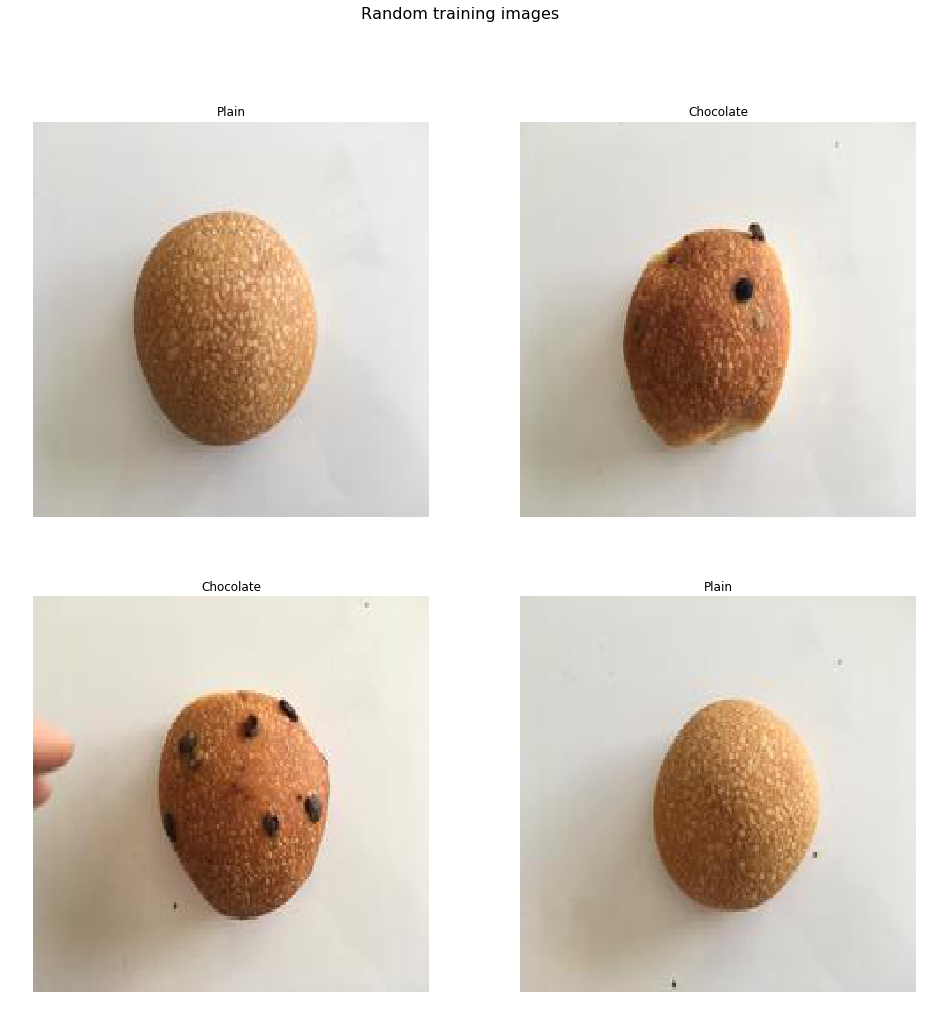

In [5]:
def plot_random_images(x, y, title=""):
    idx = np.random.choice(x.shape[0], 4, replace=False)
    imgs = x[idx]
    trgts = y[idx]
    ttls = [inv_target_names[i] for i in list(np.argmax(trgts, axis=1))]
    plt.figure(figsize=(16, 16))
    plt.suptitle(title, size=16)
    for i in range(0, 4):
        plt.subplot(221 +(i))
        plt.imshow(imgs[i])
        plt.title(str(ttls[i]))
        plt.axis('off')
    
plot_random_images(x_train, y_train, title="Random training images")

###  Data augmentation setup

Now that the data has been loaded, we are ready to setup an image generator. The idea is that a chocolate bun will still be a chocolate bun even though it has e.g. been rotated a bit. By doing different kinds of transformations of the original images, we get, in principle, an infinite number of training samples. Furthermore, the model we are going to train will be more robust to these transformations. As such, data augmentation is usually considered a very good of regularizing your deep learning model. Data augmentation is not limited to these transformations - one can be very creative as long as the augmentation will reflect something the model potentially are going to see in real life.

In [6]:
# Setup augmentation arguments
target_size = (224, 224)
batch_size = 8

augmentation_args = {
    "rotation_range": 0.5,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.1,
    "zoom_range": 0.1,
    "channel_shift_range": 0.,
    "fill_mode": 'nearest',
    "cval": 0., # Only relevant if fill_mode = constant
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": (1/255)
}

# Initialize the Data Generator
data_generator = ImageDataGenerator(**augmentation_args)

In [7]:
# Setup data generator
training_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)

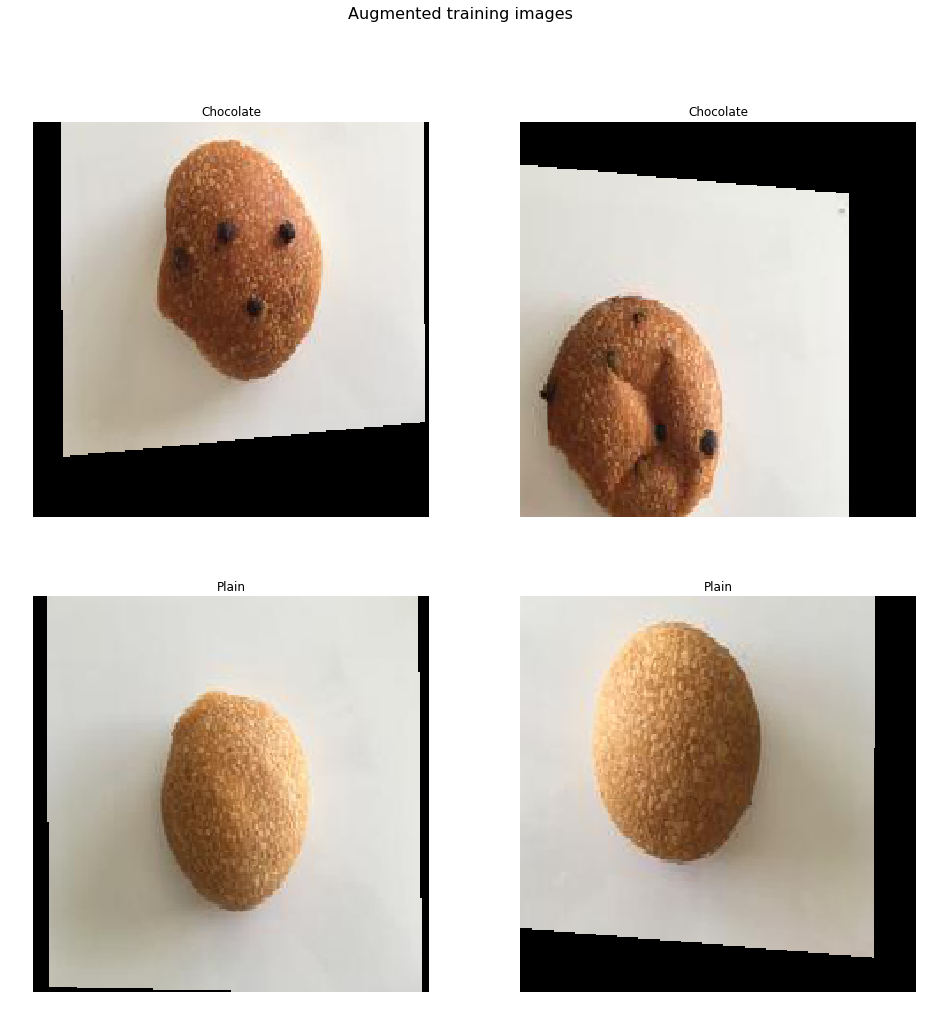

In [8]:
# Plot some augmented images
x, y = training_generator.next()
plot_random_images(x*255, y, title="Augmented training images")

###  Setup the deep learning model

THe model architecture we are going to use is called MobileNet and was developed by Google. This is just one of many recently published architectures that aim at doing inference fast enough for embedded devices and for vision applications. Deep learning for computer vision has mainly been driven by convolutional neural nets and MobileNets are no exception to this. The way MobileNet differs from many other popular convolutional neural nets are due to the factorization of the convolutional operator that allow us to decrease the number of parameters used. There are many other tricks for limiting the size of the network and interested readers can e.g. look up:
* SqueezeNet
* ENet
* ICNet

We can (down)load a version of MobileNet that has been pretrained on ImageNet. ImageNet is a database consisting of millions of images with thousand of classes. Eventhough many of these images doesn't look like buns at all, we can still leverage transfer learning. Most (or all) convolutional neural networks tend to learn many of the same features in the early layers. This can e.g. be for detecting lines, corners or circles. It is only the last layers of the network that will be very specialized to the task at hand. As such, there is no need for training the same features over and over again.

Another benefit of transfer learning is that it might improve the generalization capabilities of your model. If the model has previously been trained on a wide range of different images (like ImageNet), it has probably learned more generalized features.

In [9]:
# Load Pretrained model
base_model = MobileNet(include_top=False, alpha=0.5)

In [10]:
# See the structure of the model
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 16)      64        
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 16)      0         
__________

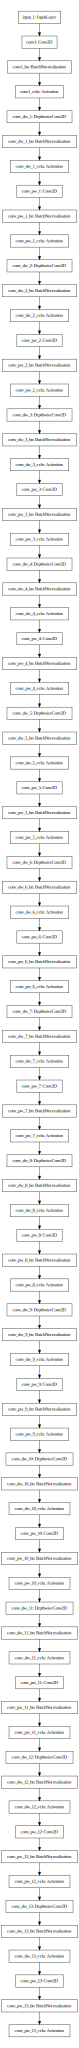

In [11]:
# See the graph of the model
SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

As we can see, the model is mainly made up of the following layers:
* Conv2D
* DeptwiseConv2D
* BatchNormalization

In order to create a classification problem, we will have to attach a classification top. We start by pooling the output of the base model and then adding a dense layer that will produce our predicted probabilities due to the softmax activation function. The model uses crossentropy as a loss and the ADAM optimizer.

### Train the model

In [12]:
# Freeze pretrained model
for layer in base_model.layers:
    layer.trainable = False

# Remember input
model_input = base_model.input

# Attatch classification top
model = GlobalAvgPool2D()(base_model.output)
model = Dense(128, activation="relu")(model)
model = Dense(nb_classes, activation="softmax")(model)

# Collect and Compile
model = Model(model_input, model)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

With these additions our model now looks like this:

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 16)      64        
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 16)      0         
__________

In [14]:
# Fit NN model
model.fit_generator(training_generator, 
                    epochs=10, 
                    steps_per_epoch=x_train.shape[0]/batch_size,
                    validation_data=(x_test, y_test))

Epoch 1/10
9/9 [==============================] - 2s - loss: 0.5205 - acc: 0.6971 - val_loss: 1.5530 - val_acc: 0.5000
Epoch 2/10
9/9 [==============================] - 1s - loss: 0.1804 - acc: 0.9306 - val_loss: 1.0187 - val_acc: 0.5500
Epoch 3/10
9/9 [==============================] - 1s - loss: 0.2678 - acc: 0.8882 - val_loss: 0.6574 - val_acc: 0.6500
Epoch 4/10
9/9 [==============================] - 1s - loss: 0.0399 - acc: 1.0000 - val_loss: 0.7204 - val_acc: 0.7000
Epoch 5/10
9/9 [==============================] - 1s - loss: 0.0327 - acc: 1.0000 - val_loss: 0.6885 - val_acc: 0.7500
Epoch 6/10
9/9 [==============================] - 1s - loss: 0.2993 - acc: 0.9162 - val_loss: 1.2511 - val_acc: 0.5500
Epoch 7/10
9/9 [==============================] - 1s - loss: 0.1776 - acc: 0.9301 - val_loss: 0.3438 - val_acc: 0.9000
Epoch 8/10
9/9 [==============================] - 1s - loss: 0.0471 - acc: 0.9860 - val_loss: 0.3953 - val_acc: 0.8500
Epoch 9/10
9/9 [==============================] 

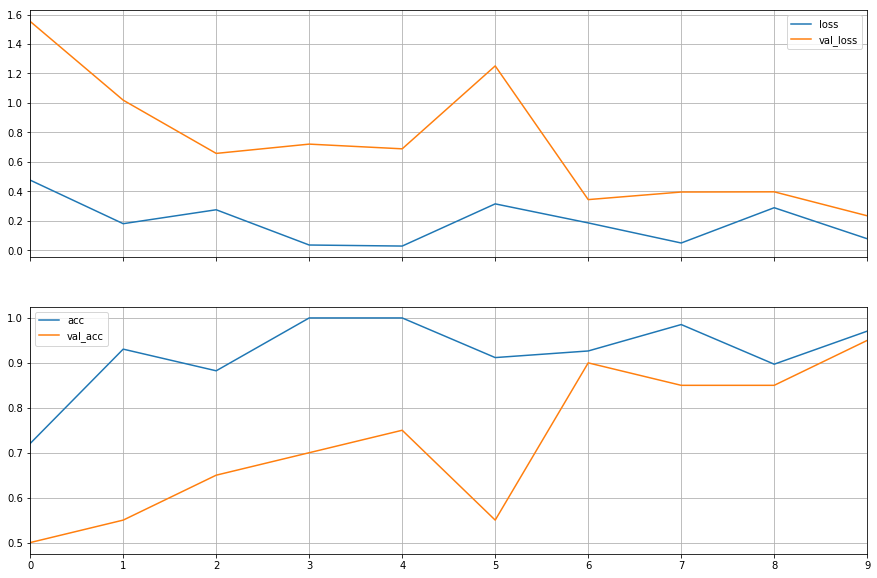

In [15]:
def plot_hist(history, series, ax=None):
    if ax is None:
        ax = plt.gca()
    for s in series:
        ax.plot(history.epoch, history.history[s])
    ax.grid(True)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.legend(series)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,10))
plot_hist(model.history, ['loss', 'val_loss'], ax[0])
plot_hist(model.history, ['acc', 'val_acc'], ax[1])

In [16]:
preds = np.argmax(model.predict(x_test), axis=1)
faulty_idx = np.where(preds!=np.argmax(y_test, axis=1))